In [1]:
DEBUG = False
MODEL_DEBUG = False
MODEL_IMPROVE_DEBUG = True

### References

<img src="https://static.vecteezy.com/system/resources/previews/000/108/974/original/vector-fashion-girl.jpg" width="700px" />

## Fashion-MNIST Classification

> Can we develop a model that performs well on the Fashion-MNIST dataset?

### Context
Fashion-MNIST is a dataset from Zalando research, comprising of <code>28 x 28</code> grayscale images of a total fo <code>70000</code> fashion products from 10 categories. The intent of this dataset is to serve as a replacement for the MNIST dataset for testing and benchmarking machine learning and deep learning models (Xiao, Rasul and Vollgraf, 2017).

The dataset is based on images from Zalando's assortment. Each original image of <code>762 x 1000</code> in JPEG format was converted to PNG, resized, and then converted to grayscale.

### Objectives
<ol>
	<li>To explore and understand the dataset</li>
	<li>Understand the effects of different data augmentation techniques on the performance of the model</li>
	<li>Develop and experiment with models in order to rival state-of-the-art (SOTA) benchmark scores</li>
</ol>

## Importing libraries
We import the necessary libraries for the notebook to run below.

In [2]:
!pip install -q einops
!pip install -q pandas
!pip install -q seaborn
!pip install -q matplotlib
!pip install -q opencv-python
!pip install -q scikit-learn

In [3]:
import math
# if not DEBUG:
# 	from MulticoreTSNE import MulticoreTSNE as TSNE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import random
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set('notebook')
from PIL import Image

import torch
from torch import nn, optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import InterpolationMode
import os

from einops import rearrange
from einops.layers.torch import Rearrange


We see the seed such that the notebook results in reproducible results when run. 

We also set the device to CUDA to enable torch to use our GPU.

In [4]:
seed = 1234
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
# When running on the CuDNN backend, two further options must be set
torch.backends.cudnn.deterministic = True
# Set a fixed value for the hash seed
os.environ['PYTHONHASHSEED'] = str(seed)
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device available now:', device)
if device != torch.device('cuda'):
    print('using cpu, exiting')
    assert False

Device available now: cuda


## Utility Functions
Below we define some utility functions that will ease and help us with our analysis.

In [5]:
def loc_data(data, loc):
	datacopy = copy.deepcopy(data)
	arr = np.array(datacopy.loc[loc].drop('label'))
	label = datacopy.loc[loc]['label']
	root = int(len(arr) ** 0.5)
	arr.resize((root, root))
	return label, arr

def imshow(arr: list, label: list = None, grayscale=True, figsize=None):
	if label == None:
		label = [''] * len(arr)

	height = int(len(arr) ** 0.5)
	width = math.ceil(len(arr) / height)

	if figsize == None:
		fig = plt.figure()
	else:
		fig = plt.figure(figsize=figsize)
	for i in range(height):
		for j in range(width):
			ax = fig.add_subplot(height, width, i * height + j + 1)
			ax.grid(False)
			ax.set_xticks([])
			ax.set_yticks([])
			ax.imshow(arr[i * height + j], cmap='gray' if grayscale else '')
			ax.set_title(label[i * height + j])

def df_to_tensor(df, shape = (28, 28)):
	return torch.tensor(df.values.reshape((-1, *shape)), dtype=torch.float32)


def preprocess(df):
	return df.applymap(lambda x: x / 255)

def mse(t1, t2, shape=(28, 28)):
	loss = nn.MSELoss(reduction='none')
	loss_result = torch.sum(loss(t1, t2), dim=2)
	loss_result = torch.sum(loss_result, dim=2)
	loss_result = loss_result / np.prod([*shape])
	return loss_result

## Dataset
Let's take a look at the dataset. This dataset was retrieved from the original Fashion MNIST dataset found at <a href="https://arxiv.org/pdf/1708.07747v2.pdf">Paper Link</a>. 

<table>
	<tr>
		<th>
			Column Name
		</th>
		<th>
			Description
		</th>
	</tr>
	<tr>
		<td>
			label
		</td>
		<td>
			The true class of the image, represented as an integer ranging from 0 to 9<strong>*</strong>
		</td>
	</tr>
	<tr>
		<td>
			pixel 1<br/>...<br/>pixel 784
		</td>
		<td>
			Pixels representing the image, each pixel ranging from 0 to 255
		</td>
	</tr>
</table>

<strong>\*</strong>Each number represents a certain dress item
```
0 -> T-shirt/top
1 -> Trouser
2 -> Pullover
3 -> Dress
4 -> Coat
5 -> Sandal
6 -> Shirt
7 -> Sneaker
8 -> Bag
9 -> Ankle boot
```

In [6]:
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Let's take a look at the training dataset

In [7]:
train = pd.read_csv('data/fashion-mnist_train.csv')
train.shape

(60000, 785)

We observe that there are a total of <code>60000</code> rows and <code>785</code> columns, which is exactly what the original paper mentioned.

### Testing for missing values and invalid data
Let's try to identify if there are any missing values

In [8]:
train.isnull().sum().sum()

0

It appears <strong>no missing values are found</strong>. We will then check for any potential typos.
<ol>
	<li>Firstly, the label should only consist of values from 0 - 9</li>
	<li>Secondly, the pixel values should only fall in between and inclusive of 0 - 255</li>
</ol>

In [9]:
print('Minimum and Maximum values of labels:', train['label'].min(), "and", train['label'].max())
print("Number of values falling outside the range (0 - 255):",
	train.applymap(
		lambda x: x < 0 or x > 255 # True if out of range
	).sum().sum()
)

Minimum and Maximum values of labels: 0 and 9
Number of values falling outside the range (0 - 255): 0


We observe that the dataset seems to be properly cleaned, thus can proceed knowing that <strong>no sign of invalid or missing data have been found.</strong>

### Preprocessing
We'll convert the data such that the range <code>0 - 255</code> becomes <code>0 - 1</code>

In [10]:
train[train.columns[train.columns != 'label']] = preprocess(train[train.columns[train.columns != 'label']])

## Exploratory Data Analysis
In the EDA, we'll be attempting to complete the following set of objectives:

### EDA Objectives
<ol>
	<li>
		Is there any <strong>class imbalance</strong>
	</li>
	<li>
		What does the <strong>average image</strong> look like?
	</li>
	<li>
		Are there <strong>any outliers/anomalies</strong>?
	</li>
</ol>
Before we begin the EDA, we first need to remove a chunk of the training data to be used as validation dataset in order to avoid data leakage due to the decisions we make during EDA.

### Validation Dataset
Let's make our validation dataset. I decided that I will <strong>not be using cross validation during the modelling process</strong> due to the following reasons:
<ul>
	<li>Time taken to train models, especially if utilising <strong>computationally expensive layers, activation functions or architecture</strong></li>
	<li>Additionally due to the sheer size of the dataset, not only does this add to increased training time but also means there is enough data such that cross validation is not necessary</li>
</ul>

We'll use a validation size of <code>10000</code> to mimic the size of the test dataset. We'll also stratify on the <code>label</code> to ensure that the model we generalizes best across all 
the classes.

In [11]:
X_train, X_val, y_train, y_val = train_test_split(train.drop('label', axis=1), train['label'], test_size = 10000 / len(train), stratify=train['label'])
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)

X_train shape: (50000, 784)
X_val shape: (10000, 784)
y_train shape: (50000,)
y_val shape: (10000,)


We see that the data have been split correctly and now we can begin our EDA!

### Signs of class imbalance?
We'll first identify the situation with class imbalance

<AxesSubplot: xlabel='label', ylabel='Count'>

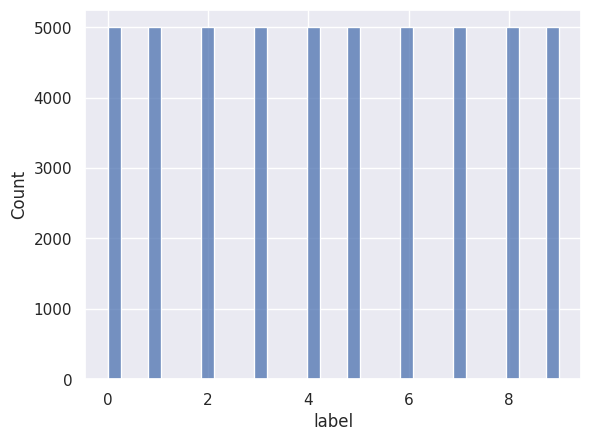

In [12]:
sns.histplot(y_train)

We observe the distribution of labels to be similar for all classes, reaching roughly a count of `5000`. Thus, there is no sign of class imbalance.

### What does the average image look like?
Let's take a look at a random sample of image each first.

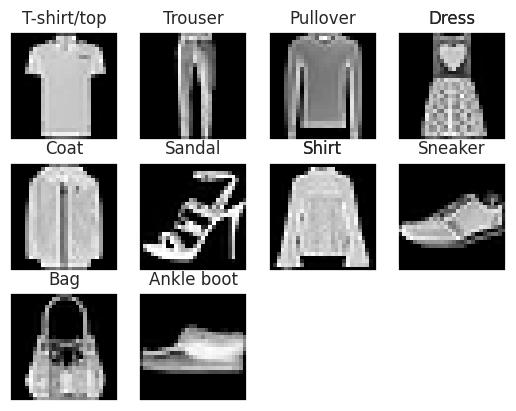

In [13]:
images = []
titles = []

for i in range(10):
	idx = random.sample(list(y_train[y_train == i].index), 1)
	images.append(X_train.loc[idx].values.reshape((28, 28)))
	titles.append(classes[y_train.loc[idx].values[0]])

imshow(images, titles)

We observe that sometimes, there appears to be certain images that are <strong>darker</strong> than others. This suggests that no form of normalization or scaling has been applied to the dataset. Let's take a look at the distribution of brightness to confirm this.

Text(0.5, 0, 'Average Brightness per Image')

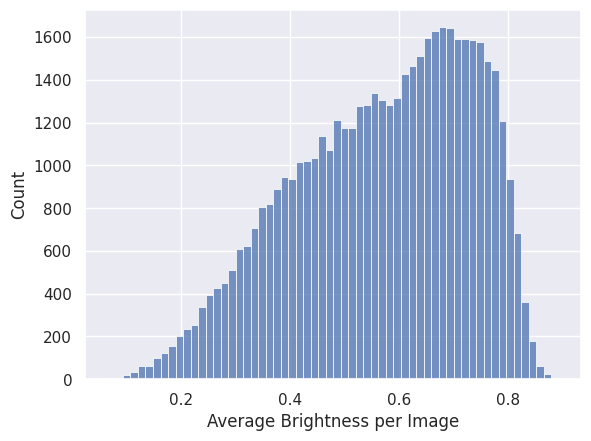

In [14]:
fig = plt.figure()
ax = fig.subplots()

# Note: we want to IGNORE the background of black, filtering by using x != 0
sns.histplot(X_train.apply(lambda x: x[x != 0].mean(), axis=1).values, ax=ax) 
ax.set_xlabel('Average Brightness per Image')

We observe:
<ol>
	<li>
		Most of the images are on the brighter side as we see a large bulk of the distribution going towards the right side.
	</li>
	<li>
		The distribution is skewed to the left, which suggests that we have a few images which are quite dark.
	</li>
</ol>


To find out what the average image looks like, we'll perform an average of the pixels across the different classes.

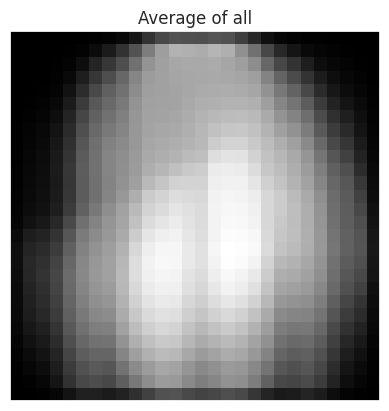

In [15]:
imshow([
	X_train.mean().apply(lambda x: x).values.reshape(28, 28)
], ['Average of all'])

We observe:
<ol>
	<li>The corners of the images are dark/black. This means there is likely no piece of clothing the spreads across the image.</li>
	<li>There is a bright circle-shape in the middle. This tells us most of these images are centered around in the middle</li>
	<li>An <strong>interesting note to point out</strong> is there seems to be some sort of darker 'bar' in the middle, separating the lightest parts of the image.</li>
	<li>
		This may be due to the presence of trousers in the dataset, as from previous images, we can see trousers appears to be the only apparel with such a contrasting stripe in the middle.
	</li>
</ol>

#### Average image among the classes
Next we'll split by the classes and find the average among them.

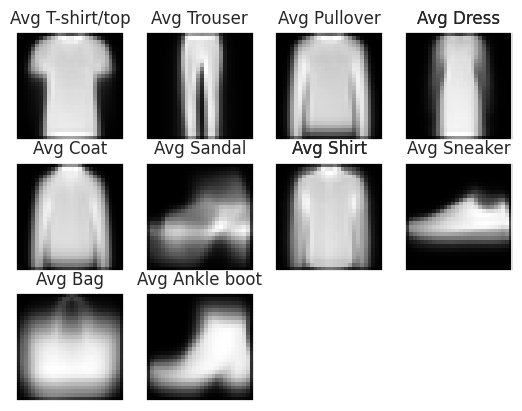

In [16]:
images = []
titles = []

for i in range(10):
	idx = random.sample(list(y_train[y_train == i].index), 1)
	images.append(X_train[y_train == i].mean().apply(lambda x: x).values.reshape(28, 28))
	titles.append(f'Avg {classes[y_train.loc[idx].values[0]]}')

imshow(images, titles)

We observe:
<ol>
	<li>Each type of apparel generally has the same shape</li>
	<li>The most <strong>spread out/least consistent</strong> class seems to be sandals, as seen from the opaque and thicker edges, where as the other types have sharper and lighter borders.</li>
</ol>


### Are there any outliers/anomalies?

We see from the average images, that the piece of clothing in the image are <strong>centered and upright</strong>, in that there are no sort of rotations going on.

As such, let's see if there may be any outlier images, such as rotations or anomaly white spots on the image.

We'll start by visualizing the dataset and seeing if outliers may exist. We can do this using <code>tSNE</code>.

In [17]:
if not DEBUG and False:
	tsne = TSNE(n_jobs=-1)
	TSNE()
	data_2d = tsne.fit_transform(X_train)

In [18]:
if not DEBUG and False:
	vis_x = data_2d[:, 0]
	vis_y = data_2d[:, 1]
	plt.scatter(vis_x, vis_y, c=y_train, cmap=plt.cm.get_cmap("jet", 10), marker='.')
	cbar = plt.colorbar(ticks=range(10))
	cbar.set_ticks([])
	for j, lab in enumerate(classes):
		cbar.ax.text(1.5, j, f'${lab}$', ha='left', va='center')

	cbar.ax.get_yaxis().labelpad = 15

	plt.clim(-0.5, 9.5)
	plt.title('Clustering Visualization with 2 components')
	plt.show()

TSNE produces an <strong>incredibly interesting visualization</strong>. We observe:
<ol>
	<li>
		There is a large breakoff of clusters at the top right. Taking a look at the classes we see that they are <code>Sneaker</code>, <code>Ankleboot</code> and <code>Sandal</code>, which are all types of footwear. 
	</li>
	<li>
		Within the footwear cluster, we recognise the classes are separated distinctly, with quite sharp edges. 
	</li>
	<li>
		The large cluster in the middle contains <code>pullover</code>, <code>dress</code>, <code>t-shirt</code> and <code>shirt</code>. This cluster seems to represent the upper body clothing.
	</li>
	<li>
		In this center cluster, the classes do not have distinct edges, but <strong>rather seem to mix and mingle together</strong>. This suggests that <code>TSNE with 2 components was unable</code> to separate these classes.
	</li>
	<li>
		Lastly, the cluster at the bottom left represents <code>bag</code>. We recognise a distinct split in the center of the cluster, suggesting that there are two types of bags.
	</li>
	<li>
		Looking at the top right cluster, we recognise some red and blue data points in the wrong cluster. This may suggest <strong>presence of outliers</strong>. Let's try to identify outliers and see how we can deal with them.
	</li>
</ol>

### Using Autoencoders to identify anomalies
The idea behind this is that we can use an autoencoder to some what <strong>compress</strong> the image, or restrict the image to its most important features. We'll train this autoencoder on minimising MSE with the original image, thus the autoencoder will learn to capture the more generic and most important features. 

Thus, after an anomaly has been passed through this autoencoder, we expect the MSE to be quite high as the anomaly image does not follow the general 'style' of the images in the dataset.

#### Defining the AutoEncoder architecture
We'll use a <strong>Convolutional Auto Encoder architecture</strong>, which is better able to extract features from images. This is because artificial neural networks do not account for proximity of each pixel to other pixels.

In [19]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1, stride=2),
            nn.LeakyReLU(),

            nn.Conv2d(8, 16, 3, padding=1, stride=2),
            nn.LeakyReLU(),

            nn.Conv2d(16, 32, 3, padding=0, stride=2),
            nn.LeakyReLU(),
        )

        self.hidden = nn.Sequential(
            nn.Flatten(start_dim = 1),
            nn.Linear(32 * 3 * 3, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 32 * 3 * 3),
            nn.LeakyReLU(),
            nn.Unflatten(1, torch.Size([32, 3, 3]))
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, output_padding=0, stride=2),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(16, 8, 3, padding=1, output_padding=1, stride=2),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(8, 1, 3, padding=1, output_padding=1, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.hidden(x)
        x = self.decoder(x)

        return x

Now that we have set up the architecture, we can instantiate the model, optimizers and criterion. To train the autoencoder, we'll be using <strong>mean squared error</strong> loss.

$$MSE = \frac{1}{n ^ 2}\sum_{i = 0}^{n}\sum_{j = 0}^{n}(X_{ij} - \hat{X}_{ij}) ^ 2$$

where $X_{ij}$ is the true value of the pixel at the $\text{i'th}$ row and $\text{j'th}$ column and   
$\hat{X}_{ij}$ is the reconstructed value of the pixel at the $\text{i'th}$ row and $\text{j'th}$ column

This is because any pixel that <strong>stands out/is an anomaly</strong> will have a <strong>heavily influence</strong> on the loss <strong>due to the square in the loss function</strong>.

In [20]:
if not DEBUG:
	model = ConvAutoencoder()
	model = model.to(device)
	model = nn.DataParallel(model)
	optimizer = optim.Adam(model.parameters(), lr=1e-3)
	criterion = nn.MSELoss()

#### Loading the dataset
Next we need to load the dataset. In order to do this, below is a custom class that acts as a wrapper <strong>to convert a pandas dataframe to PyTorch tensors</strong>, such that we are able to load the dataset into the <code>DataLoader</code> class.

In [21]:
def to_prob_dist(labels: torch.tensor, size = 10):
	arr = np.full((len(labels), size), 0)
	for i, label in enumerate(labels):
		arr[i][int(label.item())] = 1
	return torch.tensor(arr, dtype=torch.float32)

class TorchDataset():
	def __init__(self, X, y, X_shape = (1, 28, 28), y_shape = (1, )):
		if (type(X) == torch.Tensor):
			self.x = X.to(device)
		else:
			self.x = df_to_tensor(X, X_shape).to(device)

		if (type(y) == torch.Tensor):
			self.y = y.to(device)
		else:
			self.y = df_to_tensor(y, y_shape)
			self.y = to_prob_dist(self.y).to(device)

		# Transform labels to probability distributions
	
	def __len__(self):
		return len(self.y)

	def __getitem__(self, idx):
		return self.x[idx], self.y[idx]

In [22]:
train_loader = DataLoader(TorchDataset(X_train, y_train), batch_size=64, shuffle=True)

#### Training the Convolutional Auto Encoder
We can now train the auto encoder.

Epoch: 1 	Training Loss: 2.770364
Epoch: 2 	Training Loss: 1.174780
Epoch: 3 	Training Loss: 1.005342
Epoch: 4 	Training Loss: 0.913409
Epoch: 5 	Training Loss: 0.849847
Epoch: 6 	Training Loss: 0.803872
Epoch: 7 	Training Loss: 0.769925
Epoch: 8 	Training Loss: 0.741443
Epoch: 9 	Training Loss: 0.717683
Epoch: 10 	Training Loss: 0.697911
Epoch: 11 	Training Loss: 0.679764
Epoch: 12 	Training Loss: 0.665646
Epoch: 13 	Training Loss: 0.653202
Epoch: 14 	Training Loss: 0.641771
Epoch: 15 	Training Loss: 0.631592
Epoch: 16 	Training Loss: 0.622035
Epoch: 17 	Training Loss: 0.614189
Epoch: 18 	Training Loss: 0.605500
Epoch: 19 	Training Loss: 0.598067
Epoch: 20 	Training Loss: 0.590368
Epoch: 21 	Training Loss: 0.583263
Epoch: 22 	Training Loss: 0.576755
Epoch: 23 	Training Loss: 0.569883
Epoch: 24 	Training Loss: 0.564534
Epoch: 25 	Training Loss: 0.559072
Epoch: 26 	Training Loss: 0.553870
Epoch: 27 	Training Loss: 0.549682
Epoch: 28 	Training Loss: 0.544969
Epoch: 29 	Training Loss: 0.5

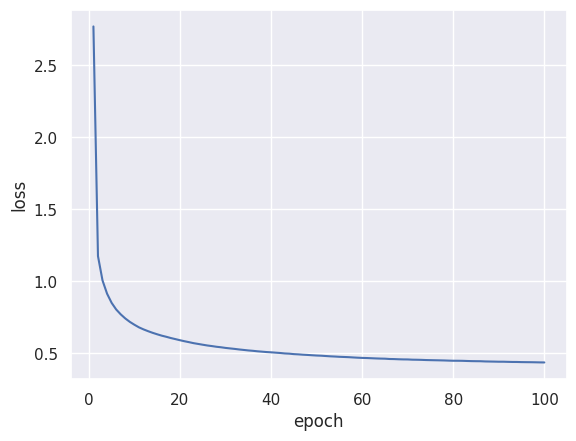

In [23]:
# number of epochs to train the model
if not DEBUG:
    n_epochs = 100

    track_loss = []

    for epoch in range(1, n_epochs+1):
        # monitor training loss
        train_loss = 0.0

        ###################
        # train the model #
        ###################
        for data in train_loader:
            # _ stands in for labels, here
            # no need to flatten images
            images, _ = data
            images = images.to(device)
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            outputs = model(images)
            # calculate the loss
            loss = criterion(outputs, images)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update running training loss
            train_loss += loss.item()*images.size(0)
                
        # print avg training statistics 
        train_loss = train_loss/len(train_loader)
        print('Epoch: {} \tTraining Loss: {:.6f}'.format(
            epoch, 
            train_loss
        ))
        track_loss.append(train_loss)

    track_loss_df = pd.DataFrame({'epoch': np.arange(1, len(track_loss) + 1), 'loss': track_loss})
    sns.lineplot(track_loss_df, x = 'epoch', y = 'loss')

#### Interpretting the results
Let's take a look at how the autoencoder works

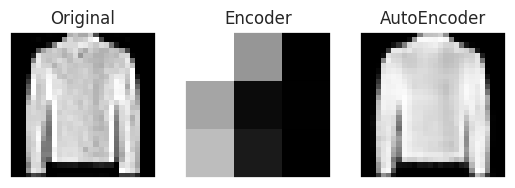

In [24]:
if not DEBUG:
	image = df_to_tensor(X_train.iloc[0], (1, 28, 28))
	image = image.to(device)
	encoder_output = model.module.encoder(image)
	model_output = model(image)
	imshow([image.cpu().numpy()[0, 0], encoder_output.cpu().detach().numpy()[0, 0], model_output.cpu().detach().numpy()[0, 0]], ['Original', 'Encoder', 'AutoEncoder'])

Now that we have a trained and working autoencoder, let's use it to identify any anomalies.

In [25]:
if not DEBUG:
	images = df_to_tensor(X_train, (1, 28, 28))
	images = images.to(device)
	outputs = model(images)

Let's take a look at the <code>99.95'th percentile</code>.

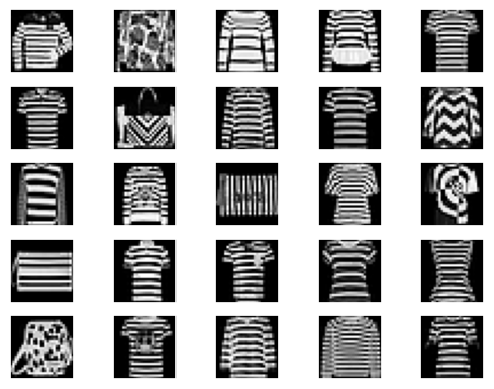

In [26]:
if not DEBUG:
	errors = mse(outputs, images).detach().cpu().numpy().flatten()
	error_boolean = errors > np.percentile(errors, 99.95)

	imshow(X_train.iloc[error_boolean].values.reshape((-1, 28, 28)))

We observe:
<ol>
	<li>
	</li>
</ol>

### Hypothesis: Footwear images only point to the left

From a view glimpses of footwear classes, we begin to recognise that it seems that all the images point to the left direction: in that the 'pointy' tip of the footwear is at the left and the heel is at the right.

Here, let's take a look at 36 randomly sampled footwear.

#### Random sampling

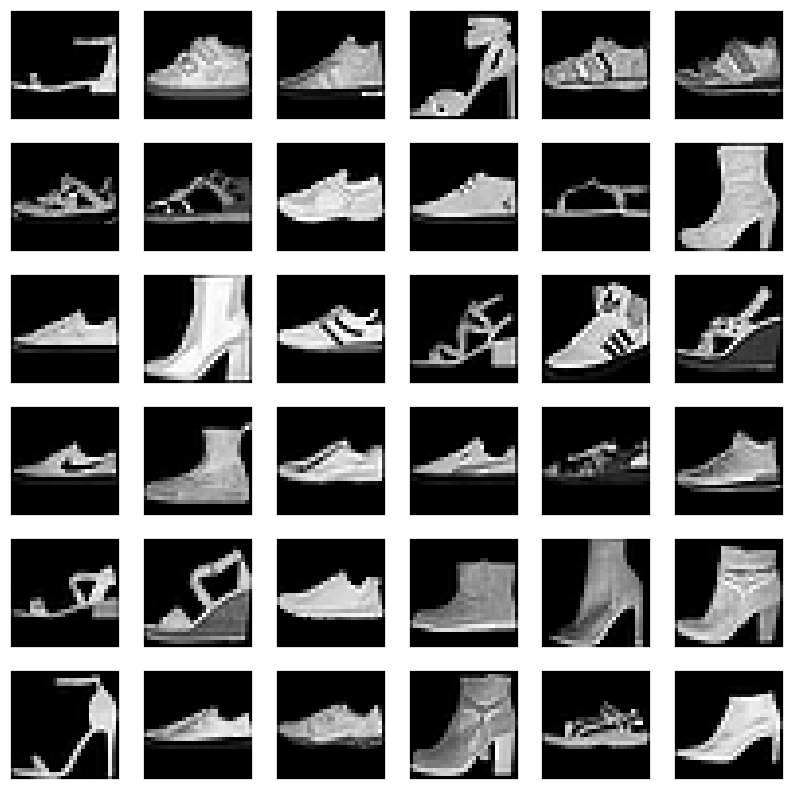

In [27]:
is_footwear = np.isin(y_train.values, [5, 7, 9])
footwear_images = X_train[is_footwear]

imshow(
	footwear_images.sample(36).values.reshape((-1, 28, 28)),
	figsize=(10, 10)
)

#### Custom Slope Algorithm for Footwear Images

To test the orientation of footwear (i.e. whether it's pointed to the left or right), we can use a slope detection algorithm.

The idea for this algorithm is below: 

```
[
	[0, 0, 0, 0, 0],
	[0, 0, 0, 1, 1],
	[0, 1, 1, 1, 1],
	[1, 1, 1, 1, 0],
	[0, 0, 0, 0, 0]
]
```

Suppose the above <code>5x5</code> is an image of our shoe. For each column, we'll find the first position where there is a non-zero value.

So for the first column it would here:

```
[
	[0, 0, 0, 0, 0],
	[0, 0, 0, 1, 1],
	[0, 1, 1, 1, 1],
	[*1*, 1, 1, 1, 0],
	[0, 0, 0, 0, 0]
]
```

For second column it would here:

```
[
	[0, 0, 0, 0, 0],
	[0, 0, 0, 1, 1],
	[0, *1*, 1, 1, 1],
	[1, 1, 1, 1, 0],
	[0, 0, 0, 0, 0]
]
```

Doing this will give us something we can call a <strong>height</strong>. For the above image, our height would be:
<code>[2, 3, 3, 4, 4]</code>

From this, we can simply determine the direction in which the slant goes. If the slant goes from low to high, it is pointed to the left, otherwise, it is pointed to the right

In [28]:
def is_left_pointed(arr):
	arr = np.array(arr)
	greater = np.where(arr.T > 0) # Gives us all index positions for non zero values
	greater_df = pd.DataFrame(greater).T # A dataframe where the first column is the column position, and the second column is the row index for non-zero values

	# We will then group by the first column (column), finding the max height for each column
	Y = len(arr) - greater_df.groupby(0).agg('min').values.flatten()
	X = np.arange(0, len(Y))
	slope = np.polyfit(X,Y,1)[0]
	return slope > 0

if not DEBUG:
	mylist = footwear_images.values.reshape((-1, 28, 28)).tolist()
	result = np.array(list(map(is_left_pointed, mylist)))

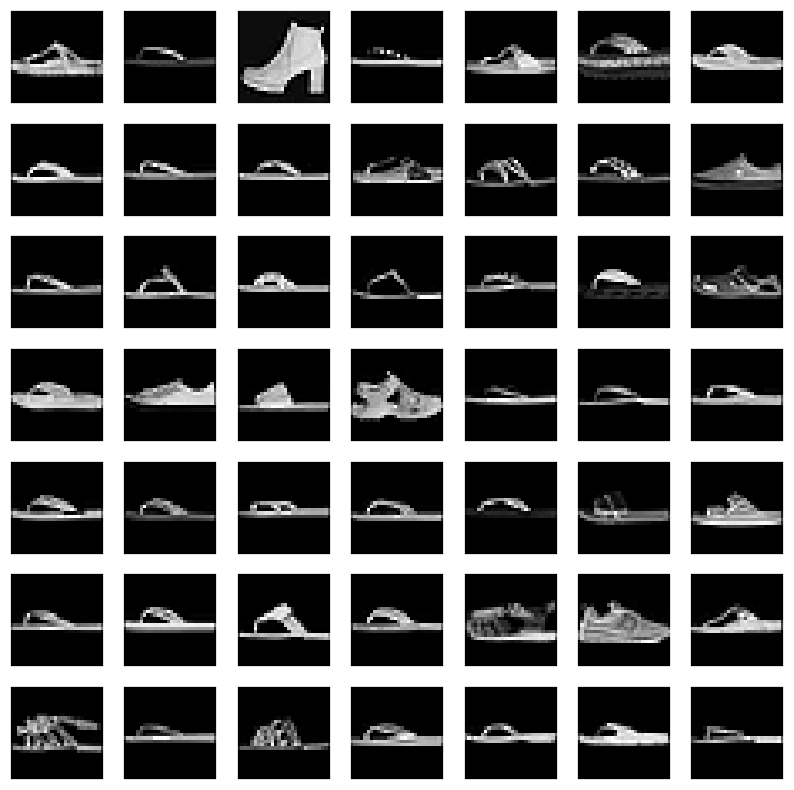

In [29]:
if not DEBUG:
	imshow(footwear_images.values.reshape((-1, 28, 28))[result == False][0:49], figsize=(10, 10))

We observe:
<ul>
	<li><strong>Most of these footwear appear to be slippers</strong>. This makes sense as our algorithm looks for the slope, which the slipper is different from something like a shoe.</li>
	<li>
		<strong>We also see images of footwear pointing to the right.</strong>
	</li>
</ul>

Thus we conclude that when performing data augmentation, we should remember to horizontally flip as well.

## Feature Engineering

We have performed feature engineering during the <strong>preprocessing step</strong>, where we divided all the values of the pixels by 255

In [30]:
normalize = transforms.Normalize((0.1307, ), (0.3081, ))

## Data Augmentation

Data augmentation is a technique used to increase the amount of data by adding slightly modified copies of existing data. It acts as a regularizer and helps reduce overfitting when training a machine learning model (Shorten and Khoshgoftaar, 2019).

As such, performing data augmentation is likely to have a positive impact on our model performance, if our model overfits.

### Basic
For our basic augmentation, I decided to perform the following transformations:
<ul>
	<li>
		<strong>RandomHorizontalFlip</strong> - this is due to the different directions the image would 'point' as seen from our EDA
	</li>
	<li>
		<strong>RandomRotation</strong> - The goal here is not to rotate by 90 degrees, but to make slight adjustments of angles such that the model becomes more robust.
	</li>
	<li>
		<strong>RandomAffine</strong> - We'll be using affine to <strong>shear</strong> the images in the y-direction. 
	</li>
</ul>

I realised there was no need to perform cropping augmentation, as working with the dataset has shown me that the images show the item fully.

In [31]:
t_flip = transforms.RandomHorizontalFlip(p=1)
t_rotate = transforms.RandomRotation((-5, 5))


t_shear = transforms.RandomChoice([
	transforms.RandomAffine(0, shear = (-10, 10, -10, 10), interpolation=InterpolationMode.NEAREST)
])

t_basic = transforms.Compose([
	normalize,
	transforms.RandomOrder([
		t_flip, t_rotate, t_shear
	])
])

Below we see how each transformation contributes to the final image.

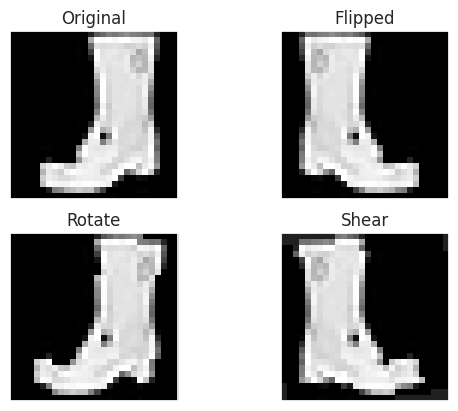

In [32]:
sample_img = copy.deepcopy(df_to_tensor(X_train.iloc[2]))
imshow([
	sample_img[0],
	t_flip(copy.deepcopy(sample_img))[0],
	t_rotate(copy.deepcopy(sample_img))[0],
	# t_shear(copy.deepcopy(sample_img))[0],
	t_basic(copy.deepcopy(sample_img))[0],
], ['Original', 'Flipped', 'Rotate', 'Shear', 'Basic'])

### RandomErasing
An additionally method of augmentation we can try is <strong>RandomErasing</strong>. RandomErasing is a data augmentation technique which randomly selects a rectangular region of the image and erases those pixels with random values. (Zhong et al., 2017)

Let's take a look:

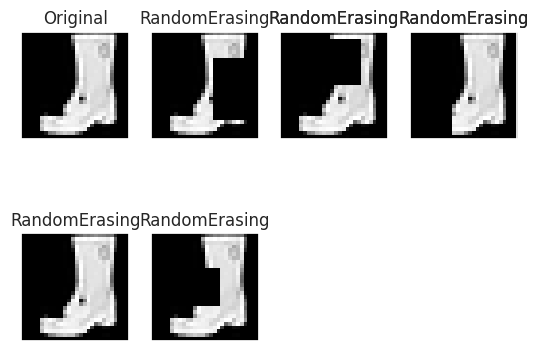

In [33]:
t_erase = transforms.RandomErasing(p = 1)

imshow([
	sample_img[0],
	t_erase(copy.deepcopy(sample_img))[0],
	t_erase(copy.deepcopy(sample_img))[0],
	t_erase(copy.deepcopy(sample_img))[0],
	t_erase(copy.deepcopy(sample_img))[0],
	t_erase(copy.deepcopy(sample_img))[0],
	t_erase(copy.deepcopy(sample_img))[0],
], ['Original', 'RandomErasing', 'RandomErasing', 'RandomErasing', 'RandomErasing', 'RandomErasing', 'RandomErasing'])

As random erasing is used on top of basic augmentation, we'll make a compose transformer of the two.

In [34]:
t_erase = transforms.Compose([
	t_basic,
	transforms.RandomErasing(p = 1)
])

## Modelling

### Metric
We'll be using two metrics: <strong>Accuracy</strong> and <strong>Categorical Crossentropy</strong>

$$accuracy = \frac{TP + TN}{TP + TN + FP + FN} $$

$$\text{categorical crossentropy} = -\sum_{i=1}^{n}y_i \log{(p_i)} $$

We use accuracy to choose the model, as the benchmarks for the Fashion MNIST dataset are in terms of accuracy. Additionally, the dataset does not have an imbalanced class issue, thus using accuracy is not unsuitable.

We use categorical crossentropy as our criterion to train the model, because it heavily penalizes models that are confident and wrong in their prediction. This is due to the logarithmic function in the cross entropy formula. 

### Set up training environment
Let's set up the necessary details for our training to begin. Firstly, <strong>we define our datasets below</strong>.

In [35]:
def perform_augmentation(torch_dataset: TorchDataset, transform):
	data_copy = copy.deepcopy(torch_dataset)
	X = copy.deepcopy(data_copy.x)
	transformed = transform(X)
	data_copy.x = torch.cat((X, transformed), dim = 0)
	data_copy.y = torch.cat([data_copy.y, data_copy.y])
	return data_copy

train_data = TorchDataset(X_train, y_train)
val_data = TorchDataset(X_val, y_val)
train_augmented_erase = perform_augmentation(TorchDataset(X_train, y_train), t_erase)

#### Custom Early Stopping
Additionally, instead of <strong>arbitrarily choosing the number of epochs</strong> or fine tuning it (which computationally will take long), I decided to use <strong>Early Stopping</strong> as a mechanism.

Overfitting is something that occurs when a model begins to extract some of the residual variation such as noise under the assumption that it is learning the patterns (Burnham and Anderson, 2010). Essentially, it starts to <strong>memorize instead of generalize</strong>. Traditional Early Stopping attempts to combat overfitting by stopping training if the performance/loss of the model on a validation set does not improve over $n$ epochs, where $n$ is the patience parameter. However, it requires <strong>clever tuning</strong> to prevent underfitting (Adam, 2018). As such to address this problem, I use a custom implemented early stopping class inspired by this <a href="https://alexadam.ca/2018/08/03/early-stopping/">article</a>.

The idea of this custom early stopping is that we <strong>only stop training</strong> if there are no improvements in <strong>both loss and accuracy</strong>. If there is an improve in any of the single quantities, the patience counter is reset. This tackles the issue of the underlying assumption that <strong>"loss is correlated with accuracy</strong>", and becomes a more lenient form of early stopping, ideally decreasing underfitting.

In [36]:
class CustomEarlyStopping():
	def __init__(self, patience, min_loss_delta = 0, min_acc_delta = 0):
		self.patience = patience
		self.best_loss = 1e9
		self.best_acc = 0
		self.patience_count = 0
		self.count = 0
		self.stop = False

		self.min_loss_delta = min_loss_delta
		self.min_acc_delta = min_acc_delta

	def __call__(self, loss, accuracy):
		self.save_state = False

		if self.best_loss - loss > self.min_loss_delta or accuracy - self.best_acc > self.min_acc_delta:
			if self.best_loss - loss > self.min_loss_delta:
				self.best_loss = loss
			if accuracy - self.best_acc > self.min_acc_delta:
				self.best_acc = accuracy

			self.count = 0
		else:
			self.count += 1
		
		if self.count >= self.patience:
			self.stop = True

#### Trainer
To help us with training and determining the best models, we set up a trainer that will <strong>keep track of our models</strong> and <strong>ease the modelling process</strong>.

In [37]:
GPU_COUNT = 2

In [38]:
def accurate_count(pred, true):
	return ((pred.argmax(dim=1) == true.argmax(dim=1)).sum()).item()

	
class Trainer():
	def __init__(self, criterion):
		self.saves = {}
		self.loss_tracker = {}
		self.history = pd.DataFrame()

	def show_history(self):
		pass

	def train_model(self, name, model_pass, optimizer_pass, optimizer_args,
					train_data: TorchDataset, scheduler_pass = None,
					scheduler_args = None, batch_size = GPU_COUNT * 128,
					early_stopping = None, epochs = 200, verbose = False,
					val_data = val_data, save_model = False, augment = None,
					return_model = False):

		model = model_pass()
		model = model.to(device)
		model = nn.DataParallel(model)

		optimizer = optimizer_pass(model.parameters(), **optimizer_args)
		criterion = nn.CrossEntropyLoss()
		train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True)
		val_loader = DataLoader(val_data, batch_size = batch_size, shuffle = True)

		if scheduler_pass != None:
			scheduler = scheduler_pass(optimizer, **scheduler_args)

		done = 0
		n_epochs = epochs
		
		track_loss = np.full((epochs, 4), 0.0, dtype=np.float32) # train acc, train loss, val acc, val loss

		best_performance_df = pd.DataFrame({'Train Loss': 1000, 'Val Loss': 1000, 'Train Acc': 0, 'Val Acc': 0}, index = [name])
		best_val_loss = 1e9

		self.end_training = 0
		self.extra_trained = 0

		for epoch in range(1, n_epochs+1):
			# monitor training loss
			train_loss = 0.0
			train_acc_count = 0
			total_sample = 0
			
			###################
			# train the model #
			###################
			for data in train_loader:
				# _ stands in for labels, here
				# no need to flatten images
				inputs, labels = data

				perform_aug = np.random.random() < 0.4
				if augment != None and perform_aug:
					batch, perm, lmbd = augment['fn'](inputs.detach().cpu(), *augment['args'], **augment['kwargs'])
					optimizer.zero_grad()

					inputs = batch.cuda()

					outputs = model(inputs)
					loss = criterion(outputs, labels) * lmbd + criterion(outputs, labels[perm]) * (1 - lmbd)
					loss.backward()
				else:
					inputs = inputs.cuda()
					labels = labels.cuda()
					# clear the gradients of all optimized variables
					optimizer.zero_grad()
					# forward pass: compute predicted outputs by passing inputs to the model
					outputs = model(inputs)
					# calculate the loss
					loss = criterion(outputs, labels)
					# backward pass: compute gradient of the loss with respect to model parameters
					loss.backward()

				# perform a single optimization step (parameter update)
				optimizer.step()
				# update running training loss
				train_loss += loss.item()

				if augment != None and perform_aug:
					new_labels = labels * lmbd + labels[perm] * (1 - lmbd)
					train_acc_count += accurate_count(outputs, new_labels)
				else:
					train_acc_count += accurate_count(outputs, labels)
				total_sample += len(labels)

			if scheduler_pass != None:
				scheduler.step()
					
			# print avg training statistics 
			train_loss = train_loss/len(train_loader)
			train_acc = train_acc_count / total_sample

			val_loss = 0.0
			val_acc_count = 0
			total_sample = 0
			for i, data in enumerate(val_loader):
				inputs, labels = data                             
				inputs = inputs.to(device)
				labels = labels.to(device)
																
				outputs = model(inputs)
				loss = criterion(outputs, labels)

				val_loss += loss.item()
				val_acc_count += accurate_count(outputs, labels)
				total_sample += len(labels)

			val_loss = val_loss / len(val_loader)
			val_acc = val_acc_count / total_sample

			if verbose:
				print(f"Epoch: {epoch} | Train Loss: {train_loss:.5f} \tVal Loss: {val_loss:.5f} \tTrain Acc: {train_acc:.3f} \tVal Acc: {val_acc:.3f}")

			track_loss[epoch - 1][0] = train_acc
			track_loss[epoch - 1][1] = train_loss
			track_loss[epoch - 1][2] = val_acc
			track_loss[epoch - 1][3] = val_loss
			done = epoch

			if val_loss < best_val_loss:
				best_performance_df = pd.DataFrame({'Train Loss': train_loss, 'Val Loss': val_loss, 'Train Acc': train_acc, 'Val Acc': val_acc}, index = [name])
				self.end_training = epoch
				best_val_loss = val_loss
				if save_model:
					self.save_model(name, model)

			early_stopping(val_loss, val_acc)

			if early_stopping != None and early_stopping.stop:
				if (verbose):
					print(f"Stopping due to early stopping | patience = {early_stopping.patience}")
				break


		track_loss.resize((done, 4))
		self.record(name, track_loss, best_performance_df)

		if return_model:
			del train_loader, val_loader, inputs, labels
			torch.cuda.empty_cache()
			return model
		else:
			del model, optimizer, train_loader, val_loader, inputs, labels
			torch.cuda.empty_cache()

	def record(self, name, track_loss, best_performance_df):
		track_loss_df = pd.DataFrame(track_loss, columns=['Train Acc', 'Train Loss', 'Val Acc', 'Val Loss'])
		track_loss_df.index += 1
		track_loss_df.index.name = 'Epoch'

		self.history = pd.concat([self.history, best_performance_df], axis=0)
		self.loss_tracker[name] = track_loss_df

	def save_model(self, name, model):
		self.saves[name] = copy.deepcopy(model)

	def get_model(self, name):
		return copy.deepcopy(self.saves[name])

	def archive(self, name):
		fig = plt.figure(figsize=(14, 5))
		train, val = sns.color_palette('Set2')[0:2]
		loss, acc = fig.subplots(1, 2)

		loss.axvspan(1, self.end_training, color=sns.color_palette('Paired')[0], alpha=0.4, lw=0, label='Training') 

		loss.plot(self.loss_tracker[name].index, self.loss_tracker[name]['Train Loss'], label='Train', color=train)
		loss.plot(self.loss_tracker[name].index, self.loss_tracker[name]['Val Loss'], label='Val', color=val)
		loss.set_xlabel('Epoch')
		loss.set_ylabel('Loss')

		acc.axvspan(1, self.end_training, color=sns.color_palette('Paired')[0], alpha=0.4, lw=0, label='Training') 
		acc.plot(self.loss_tracker[name].index, self.loss_tracker[name]['Train Acc'], label='Train', color=train)
		acc.plot(self.loss_tracker[name].index, self.loss_tracker[name]['Val Acc'], label='Val', color=val)

		acc.set_xlabel('Epoch')
		acc.set_ylabel('Accuracy')
		acc.set_ylim(0.60, 1)


		acc.legend()
		loss.legend()
		
		fig.savefig(f'plots/{name}.png')
		plt.close()
		del self.loss_tracker[name]

We instantiate our trainer with our validation data, along with our loss function: <strong>categorical crossentropy</strong>

In [39]:
trainer = Trainer(nn.CrossEntropyLoss)

### Model Architectures
We can now get started with determining the best non-fine-tuned model to proceed with.

#### Baseline - NN
As our baseline, we'll use a simple neural network consisting of:
<ol>
<li>Linear layer</li>
<li>Batch Normalization</li>
<li>ReLU</li>
</ol>

In [40]:
if not MODEL_DEBUG:
    class BaseNN(nn.Module):
        def __init__(self):
            super(BaseNN, self).__init__()

            self.flat = nn.Flatten(1)

            self.fc1 = nn.Linear(784, 256)
            self.fc1_bn = nn.BatchNorm1d(256)
            self.fc1_act = nn.ReLU()

            self.fc2 = nn.Linear(256, 64)
            self.fc2_bn = nn.BatchNorm1d(64)
            self.fc2_act = nn.ReLU()

            self.fc3 = nn.Linear(64, 16)
            self.fc3_bn = nn.BatchNorm1d(16)
            self.fc3_act = nn.ReLU()

            self.fc4 = nn.Linear(16, 10)
            self.fc4_bn = nn.BatchNorm1d(10)
            self.fc4_act = nn.ReLU()

        def get_logits(self, x):
            x = self.flat(x)
            x = self.fc1_act(self.fc1_bn(self.fc1(x)))
            x = self.fc2_act(self.fc2_bn(self.fc2(x)))
            x = self.fc3_act(self.fc3_bn(self.fc3(x)))
            x = self.fc4_act(self.fc4_bn(self.fc4(x)))
            logits = x
            return logits

        def forward(self, x):
            logits = self.get_logits(x)
            return nn.functional.softmax(logits, dim=1)

In [41]:
if not MODEL_DEBUG:
	trainer.train_model(
		'Baseline NN', BaseNN, # model
		optim.Adam, {'lr': 1e-3 * (GPU_COUNT) ** 0.5}, # optimizer
		train_data, # data
		early_stopping = CustomEarlyStopping(patience = 15),
		verbose=True
	)
	trainer.archive('Baseline NN')
	display(trainer.history)

Epoch: 1 | Train Loss: 1.82738 	Val Loss: 1.74378 	Train Acc: 0.819 	Val Acc: 0.854
Epoch: 2 | Train Loss: 1.69874 	Val Loss: 1.67220 	Train Acc: 0.864 	Val Acc: 0.868
Epoch: 3 | Train Loss: 1.64767 	Val Loss: 1.64159 	Train Acc: 0.876 	Val Acc: 0.874
Epoch: 4 | Train Loss: 1.62245 	Val Loss: 1.62654 	Train Acc: 0.884 	Val Acc: 0.879
Epoch: 5 | Train Loss: 1.60528 	Val Loss: 1.61514 	Train Acc: 0.889 	Val Acc: 0.881
Epoch: 6 | Train Loss: 1.59454 	Val Loss: 1.61522 	Train Acc: 0.893 	Val Acc: 0.877
Epoch: 7 | Train Loss: 1.58516 	Val Loss: 1.59794 	Train Acc: 0.897 	Val Acc: 0.884
Epoch: 8 | Train Loss: 1.57687 	Val Loss: 1.61329 	Train Acc: 0.902 	Val Acc: 0.872
Epoch: 9 | Train Loss: 1.57421 	Val Loss: 1.59741 	Train Acc: 0.902 	Val Acc: 0.882
Epoch: 10 | Train Loss: 1.56738 	Val Loss: 1.59496 	Train Acc: 0.907 	Val Acc: 0.881
Epoch: 11 | Train Loss: 1.56352 	Val Loss: 1.58836 	Train Acc: 0.909 	Val Acc: 0.887
Epoch: 12 | Train Loss: 1.56059 	Val Loss: 1.58937 	Train Acc: 0.910 	Val 

,Train Loss,Val Loss,Train Acc,Val Acc
Baseline NN,1.495565,1.562087,0.9665,0.9006


<img src="plots/Baseline NN.png">

We observe:
<ul>
	<li>Despite using early stopping, we can identify <strong>large amounts of overfitting</strong></li>
	<li>This suggests not that early stopping is bad, but using this model means we allow the model to overfit, <strong>as long as the validation is improving.</strong></li>
	<li>This means that training is perhaps inefficient but not terrible, as for each epoch, <strong>we learn more noise than pattern</strong></li>
	<li>With a patience parameter of <code>10</code>, Early Stopping has stopped our training at <strong>Epoch = 20</strong></li>
	<li>Surprisingly, the baseline performance is impressive for a basic model at 0.89 accuracy</strong>
</ul>

#### Augmentation + Baseline NN

In [42]:
if not MODEL_DEBUG:
	trainer.train_model(
		'Baseline NN + Aug_Erase', BaseNN, # model
		optim.Adam, {'lr': 1e-3 * (GPU_COUNT) ** 0.5}, # optimizer
		train_augmented_erase, # data
		early_stopping = CustomEarlyStopping(patience = 15),
		verbose=True
	)
	trainer.archive('Baseline NN + Aug_Erase')
	display(trainer.history)

Epoch: 1 | Train Loss: 1.79782 	Val Loss: 1.71332 	Train Acc: 0.804 	Val Acc: 0.837
Epoch: 2 | Train Loss: 1.66746 	Val Loss: 1.66226 	Train Acc: 0.849 	Val Acc: 0.847
Epoch: 3 | Train Loss: 1.63152 	Val Loss: 1.64614 	Train Acc: 0.860 	Val Acc: 0.850
Epoch: 4 | Train Loss: 1.61472 	Val Loss: 1.62289 	Train Acc: 0.866 	Val Acc: 0.860
Epoch: 5 | Train Loss: 1.60381 	Val Loss: 1.62370 	Train Acc: 0.871 	Val Acc: 0.857
Epoch: 6 | Train Loss: 1.59654 	Val Loss: 1.62076 	Train Acc: 0.875 	Val Acc: 0.859
Epoch: 7 | Train Loss: 1.58997 	Val Loss: 1.61064 	Train Acc: 0.880 	Val Acc: 0.864
Epoch: 8 | Train Loss: 1.58637 	Val Loss: 1.61450 	Train Acc: 0.882 	Val Acc: 0.862
Epoch: 9 | Train Loss: 1.58099 	Val Loss: 1.60473 	Train Acc: 0.886 	Val Acc: 0.867
Epoch: 10 | Train Loss: 1.58001 	Val Loss: 1.61129 	Train Acc: 0.886 	Val Acc: 0.862
Epoch: 11 | Train Loss: 1.57849 	Val Loss: 1.60873 	Train Acc: 0.886 	Val Acc: 0.862
Epoch: 12 | Train Loss: 1.57511 	Val Loss: 1.60834 	Train Acc: 0.889 	Val 

,Train Loss,Val Loss,Train Acc,Val Acc
Baseline NN,1.495565,1.562087,0.96650,0.9006
Baseline NN + Aug_Erase,1.548756,1.585876,0.91343,0.8776


We observe:

#### Convolutional Neural Networks (LeNet)

Convolutional Neural Networks (also known as ConvNets or CNNs) is a class of neural networks, with its most popular use case being in analyzing visual imagery (Valueva et al., 2020).

We'll use the LNet architecture.

In [43]:
if not MODEL_DEBUG:
	class LeNet(nn.Module):
		def __init__(self):
			super(LeNet, self).__init__()

			self.conv1 = nn.Conv2d(1, 6, 5, padding = 2)
			self.sig1 = nn.Sigmoid()
			self.pool1 = nn.AvgPool2d(2, stride=2)

			self.conv2 = nn.Conv2d(6, 16, 5, padding = 0)
			self.sig2 = nn.Sigmoid()
			self.pool2 = nn.AvgPool2d(2, stride=2)

			self.flat = nn.Flatten(start_dim=1)

			self.fc1 = nn.Linear(16 * 5 * 5, 120)
			self.sig_fc1 = nn.Sigmoid()

			self.fc2 = nn.Linear(120, 84)
			self.sig_fc2 = nn.Sigmoid()

			self.fc3 = nn.Linear(84, 10)

		def forward(self, x):
			x = self.pool1(self.sig1(self.conv1(x)))
			x = self.pool2(self.sig2(self.conv2(x)))
			x = self.flat(x)
			x = self.sig_fc1(self.fc1(x))
			x = self.sig_fc2(self.fc2(x))
			x = self.fc3(x)
			return x

In [44]:
if not MODEL_DEBUG:
	trainer.train_model(
		'LeNet', LeNet, # model
		optim.Adam, {'lr': 1e-3 * (GPU_COUNT) ** 0.5, 'weight_decay': 1e-5}, # optimizer
		train_data, # data
		early_stopping = CustomEarlyStopping(patience = 15),
		verbose=False
	)
	trainer.archive('LeNet')
	display(trainer.history)

,Train Loss,Val Loss,Train Acc,Val Acc
Baseline NN,1.495565,1.562087,0.96650,0.9006
Baseline NN + Aug_Erase,1.548756,1.585876,0.91343,0.8776
LeNet,0.180844,0.256414,0.93252,0.9076


#### Augmentation + CNN (LeNet)

In [45]:
if not MODEL_DEBUG:
	trainer.train_model(
		'LeNet + Aug_Erase', LeNet, # model
		optim.Adam, {'lr': 1e-3 * (GPU_COUNT) ** 0.5, 'weight_decay': 1e-5}, # optimizer
		train_augmented_erase, # data
		early_stopping = CustomEarlyStopping(patience = 15),
		verbose=False
	)
	trainer.archive('LeNet + Aug_Erase')
	display(trainer.history)

,Train Loss,Val Loss,Train Acc,Val Acc
Baseline NN,1.495565,1.562087,0.96650,0.9006
Baseline NN + Aug_Erase,1.548756,1.585876,0.91343,0.8776
LeNet,0.180844,0.256414,0.93252,0.9076
LeNet + Aug_Erase,0.219330,0.250593,0.91838,0.9060


We observe:

#### ResNet-S

In [46]:
if not MODEL_DEBUG:
	def relu_bn_conv(in_channels, out_channels, **kwargs):
		return nn.Sequential(
			nn.Conv2d(in_channels, out_channels, **kwargs),
			nn.BatchNorm2d(out_channels),
			nn.ReLU()
		)

	class ResBlock(nn.Module):
		def __init__(self, in_channels, out_channels, skip = False):
			super().__init__()
			self.skip = nn.Sequential()
			self.conv1 = relu_bn_conv(in_channels, out_channels, kernel_size = 3, padding = 1)

			if skip:
				self.conv1 = relu_bn_conv(in_channels, out_channels, kernel_size = 3, stride = 2, padding = 1)
				self.skip = nn.Conv2d(in_channels, out_channels, kernel_size= 1, stride = 2)

			self.conv2 = relu_bn_conv(out_channels, out_channels, kernel_size = 3, padding = 1)

		def forward(self, x):
			skip = self.skip(x)
			x = self.conv1(x)
			x = self.conv2(x)
			x = x + skip
			return nn.ReLU()(x)

In [47]:
if not MODEL_DEBUG:
	class ResNetS(nn.Module):
		def __init__(self, base_filter = 16):
			super().__init__()

			in_channels = 1
			
			self.l0 = nn.Sequential(
				nn.Conv2d(in_channels, base_filter, kernel_size = 7, stride = 2, padding = 3),
				nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1),
				nn.BatchNorm2d(base_filter),
				nn.ReLU()
			)
			self.l1 = nn.Sequential(
				ResBlock(base_filter, base_filter, skip = False),
				ResBlock(base_filter, base_filter, skip = False),
			)
			self.l2 = nn.Sequential(
				ResBlock(base_filter, base_filter * 2, skip = True),
				ResBlock(base_filter * 2, base_filter * 2, skip = False),
			)
			self.l3 = nn.Sequential(
				ResBlock(base_filter * 2, base_filter * 3, skip = True),
				ResBlock(base_filter * 3, base_filter * 3, skip = False),
			)
			self.gap = torch.nn.AdaptiveAvgPool2d(1)
			self.fc = nn.Sequential(
				nn.Flatten(start_dim=1),
				torch.nn.Linear(base_filter * 3, 10)
			)

		def forward(self, x):
			x = self.l0(x)
			x = self.l1(x)
			x = self.l2(x)
			x = self.l3(x)
			x = self.gap(x)
			x = self.fc(x)

			return x

In [48]:
if not MODEL_DEBUG:
	trainer.train_model(
		'ResNet-S', ResNetS, # model
		optim.Adam, {'lr': 1e-3 * (GPU_COUNT) ** 0.5, 'weight_decay': 1e-5}, # optimizer
		train_data, # data
		early_stopping = CustomEarlyStopping(patience = 15),
		verbose=False
	)
	trainer.archive('ResNet-S')
	display(trainer.history)

,Train Loss,Val Loss,Train Acc,Val Acc
Baseline NN,1.495565,1.562087,0.96650,0.9006
Baseline NN + Aug_Erase,1.548756,1.585876,0.91343,0.8776
LeNet,0.180844,0.256414,0.93252,0.9076
LeNet + Aug_Erase,0.219330,0.250593,0.91838,0.9060
ResNet-S,0.176159,0.278285,0.93336,0.8996


#### Augmentation + ResNet-S

In [49]:
if not MODEL_DEBUG:
	trainer.train_model(
		'ResNet-S + Aug_Erase', ResNetS, # model
		optim.Adam, {'lr': 1e-3 * (GPU_COUNT) ** 0.5, 'weight_decay': 1e-5}, # optimizer
		train_augmented_erase, # data
		early_stopping = CustomEarlyStopping(patience = 15),
		verbose=False
	)
	trainer.archive('ResNet-S + Aug_Erase')
	display(trainer.history)

,Train Loss,Val Loss,Train Acc,Val Acc
Baseline NN,1.495565,1.562087,0.96650,0.9006
Baseline NN + Aug_Erase,1.548756,1.585876,0.91343,0.8776
LeNet,0.180844,0.256414,0.93252,0.9076
LeNet + Aug_Erase,0.219330,0.250593,0.91838,0.9060
ResNet-S,0.176159,0.278285,0.93336,0.8996
ResNet-S + Aug_Erase,0.217970,0.331463,0.91796,0.8804


#### ResNet18

In [50]:
if not MODEL_DEBUG:
	class ResNet18(nn.Module):
		def __init__(self, base_filter = 64):
			super().__init__()

			in_channels = 1
			
			self.l0 = nn.Sequential(
				nn.Conv2d(in_channels, base_filter, kernel_size = 7, stride = 2, padding = 3),
				nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1),
				nn.BatchNorm2d(base_filter),
				nn.ReLU()
			)
			self.l1 = nn.Sequential(
				ResBlock(base_filter, base_filter, skip = False),
				ResBlock(base_filter, base_filter, skip = False),
			)
			self.l2 = nn.Sequential(
				ResBlock(base_filter, base_filter * 2, skip = True),
				ResBlock(base_filter * 2, base_filter * 2, skip = False),
			)
			self.l3 = nn.Sequential(
				ResBlock(base_filter * 2, base_filter * 3, skip = True),
				ResBlock(base_filter * 3, base_filter * 3, skip = False),
			)
			self.l4 = nn.Sequential(
				ResBlock(base_filter * 3, base_filter * 4, skip = True),
				ResBlock(base_filter * 4, base_filter * 4, skip = False),
			)
			self.gap = torch.nn.AdaptiveAvgPool2d(1)
			self.fc = nn.Sequential(
				nn.Flatten(start_dim=1),
				torch.nn.Linear(base_filter * 4, 10)
			)

		def forward(self, x):
			x = self.l0(x)
			x = self.l1(x)
			x = self.l2(x)
			x = self.l3(x)
			x = self.l4(x)
			x = self.gap(x)
			x = self.fc(x)

			return x


In [51]:
if not MODEL_DEBUG:
	trainer.train_model(
		'ResNet18', ResNet18, # model
		optim.Adam, {'lr': 1e-3 * (GPU_COUNT) ** 0.5, 'weight_decay': 1e-5}, # optimizer
		train_data, # data
		early_stopping = CustomEarlyStopping(patience = 15),
		verbose=False
	)
	trainer.archive('ResNet18')
	display(trainer.history)

,Train Loss,Val Loss,Train Acc,Val Acc
Baseline NN,1.495565,1.562087,0.96650,0.9006
Baseline NN + Aug_Erase,1.548756,1.585876,0.91343,0.8776
LeNet,0.180844,0.256414,0.93252,0.9076
LeNet + Aug_Erase,0.219330,0.250593,0.91838,0.9060
ResNet-S,0.176159,0.278285,0.93336,0.8996
ResNet-S + Aug_Erase,0.217970,0.331463,0.91796,0.8804
ResNet18,0.243367,0.268206,0.90966,0.8995


#### Augmentation + ResNet18

In [52]:
if not MODEL_DEBUG:
	trainer.train_model(
		'ResNet18 + Aug_Erase', ResNet18, # model
		optim.Adam, {'lr': 1e-3 * (GPU_COUNT) ** 0.5, 'weight_decay': 1e-5}, # optimizer
		train_augmented_erase, # data
		early_stopping = CustomEarlyStopping(patience = 15),
		verbose=False,
		batch_size=256
	)
	trainer.archive('ResNet18 + Aug_Erase')
	display(trainer.history)

,Train Loss,Val Loss,Train Acc,Val Acc
Baseline NN,1.495565,1.562087,0.96650,0.9006
Baseline NN + Aug_Erase,1.548756,1.585876,0.91343,0.8776
LeNet,0.180844,0.256414,0.93252,0.9076
LeNet + Aug_Erase,0.219330,0.250593,0.91838,0.9060
ResNet-S,0.176159,0.278285,0.93336,0.8996
ResNet-S + Aug_Erase,0.217970,0.331463,0.91796,0.8804
ResNet18,0.243367,0.268206,0.90966,0.8995
ResNet18 + Aug_Erase,0.222904,0.301207,0.91597,0.8888


#### VGG13

In [53]:
def VGGBlock(in_channels, out_channels, pool = False, activation = nn.ReLU):
	if pool:
		return nn.Sequential(
			nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
			nn.BatchNorm2d(out_channels),
			activation(),
			nn.MaxPool2d(kernel_size = 2, stride = 2)
		)
	return nn.Sequential(
		nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
		nn.BatchNorm2d(out_channels),
		activation()
	)

class VGG13(nn.Module):
	def __init__(self):
		super().__init__()
		self.l0 = VGGBlock(1, 64)
		self.l1 = VGGBlock(64, 64, pool = True)
		self.l2 = VGGBlock(64, 128)
		self.l3 = VGGBlock(128, 128, pool = True)
		self.l4 = VGGBlock(128, 256)
		self.l5 = VGGBlock(256, 256)
		self.l6 = VGGBlock(256, 256, pool = True)
		self.l7 = VGGBlock(256, 512)
		self.l8 = VGGBlock(512, 512)
		self.l9 = VGGBlock(512, 512, pool = True)
		self.fc0 = nn.Sequential(
			nn.Flatten(start_dim = 1),
			nn.Dropout(0.5),
			nn.Linear(512, 4096),
			nn.ReLU()
		)
		self.fc1 = nn.Sequential(
			nn.Dropout(0.5),
			nn.Linear(4096, 4096),
			nn.ReLU()
		)
		self.fc2 = nn.Sequential(
			nn.Linear(4096, 10)
		)

	def forward(self, x):
		x = self.l0(x)
		x = self.l1(x)
		x = self.l2(x)
		x = self.l3(x)
		x = self.l4(x)
		x = self.l5(x)
		x = self.l6(x)
		x = self.l7(x)
		x = self.l8(x)
		x = self.l9(x)
		x = self.fc0(x)
		x = self.fc1(x)
		x = self.fc2(x)
		return x
    
	def __repr__(self):
		return "VGG13"

In [54]:
if not MODEL_DEBUG:
	trainer.train_model(
		'VGG13', VGG13, # model
		optim.Adam, {'lr': 1e-3 * (GPU_COUNT) ** 0.5, 'weight_decay': 1e-5}, # optimizer
		train_data, # data
		early_stopping = CustomEarlyStopping(patience = 15),
		verbose=False
	)
	trainer.archive('VGG13')
	display(trainer.history)

,Train Loss,Val Loss,Train Acc,Val Acc
Baseline NN,1.495565,1.562087,0.96650,0.9006
Baseline NN + Aug_Erase,1.548756,1.585876,0.91343,0.8776
LeNet,0.180844,0.256414,0.93252,0.9076
LeNet + Aug_Erase,0.219330,0.250593,0.91838,0.9060
ResNet-S,0.176159,0.278285,0.93336,0.8996
ResNet-S + Aug_Erase,0.217970,0.331463,0.91796,0.8804
ResNet18,0.243367,0.268206,0.90966,0.8995
ResNet18 + Aug_Erase,0.222904,0.301207,0.91597,0.8888
VGG13,0.126612,0.237470,0.95740,0.9300



#### Augmentation + VGG


In [55]:
if not MODEL_DEBUG:
	trainer.train_model(
		'VGG13 + Aug_Erase', VGG13, # model
		optim.Adam, {'lr': 1e-3 * (GPU_COUNT) ** 0.5, 'weight_decay': 1e-5}, # optimizer
		train_augmented_erase, # data
		early_stopping = CustomEarlyStopping(patience = 15),
		verbose=False
	)
	trainer.archive('VGG13 + Aug_Erase')
	display(trainer.history)

,Train Loss,Val Loss,Train Acc,Val Acc
Baseline NN,1.495565,1.562087,0.96650,0.9006
Baseline NN + Aug_Erase,1.548756,1.585876,0.91343,0.8776
LeNet,0.180844,0.256414,0.93252,0.9076
LeNet + Aug_Erase,0.219330,0.250593,0.91838,0.9060
ResNet-S,0.176159,0.278285,0.93336,0.8996
ResNet-S + Aug_Erase,0.217970,0.331463,0.91796,0.8804
ResNet18,0.243367,0.268206,0.90966,0.8995
ResNet18 + Aug_Erase,0.222904,0.301207,0.91597,0.8888
VGG13,0.126612,0.237470,0.95740,0.9300
VGG13 + Aug_Erase,0.150787,0.214775,0.94743,0.9279


We observe:
	Deep convolution structure performs better than residual networks.

#### Modified CoAtNet-0
With the rise in transformers, there has been a growing interest in the <strong>Attention mechanism</strong> and its uses in computer vision.

The problem is inductive bias of vision transformers, without being pretrained on a dataset, the performance is found to be worse than state of the art convnet. (https://analyticsindiamag.com/a-guide-to-coatnet-the-combination-of-convolution-and-attention-networks/). 

Below, we use CoAtNet-0, which is an architecture that <strong>marries</strong> Convolution blocks (specifically MBConvs from MobileNet) and Transformer Blocks"

However, the smallest model CoAtNet-0 is quite an overkill for this dataset due to it's large number of parameters, despite being the smallest version. As such, we the following adjustments to make the model smaller.

<ul>
	<li>Change from the architecture of
	<code>Conv + Conv + Trans + Trans -> Conv + Conv + Conv + Trans </code>
	</li>
	<li>
	<strong>Reduced</strong> downsampling frequency to downsample only at layer 3 and 5. This is such due <strong>to the smaller image size</strong> of our data being <code>28x28</code>.
	</li>
	<li>
		<strong>Downsampling frequency skewed to the right</strong>. This means we move the downsampling layers towards the later, such that we can <strong>increase the amount of information that the earlier layers can capture.</strong>
	</li>
	<li>
		The <strong>number of blocks and channels were also reduced</strong>. This is done as the dataset is quite small and does not need an incredibly deep network (CoAtNet-0 was originally meant for <code>224x224x3</code> images)
	</li>
</ul>

In [56]:
def conv_3x3_bn(inp, oup, image_size, downsample=False):
    stride = 1 if downsample == False else 2
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.GELU()
    )


class PreNorm(nn.Module):
    def __init__(self, dim, fn, norm):
        super().__init__()
        self.norm = norm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)


class SE(nn.Module):
    def __init__(self, inp, oup, expansion=0.25):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(oup, int(inp * expansion), bias=False),
            nn.GELU(),
            nn.Linear(int(inp * expansion), oup, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y


class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)


class MBConv(nn.Module):
    def __init__(self, inp, oup, image_size, downsample=False, expansion=4):
        super().__init__()
        self.downsample = downsample
        stride = 1 if self.downsample == False else 2
        hidden_dim = int(inp * expansion)


        self.pool = nn.MaxPool2d(3, 2, 1)
        self.proj = nn.Conv2d(inp, oup, 1, 1, 0, bias=False)

        if expansion == 1:
            self.conv = nn.Sequential(
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride,
                          1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.GELU(),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(
                # pw
                # down-sample in the first conv
                nn.Conv2d(inp, hidden_dim, 1, stride, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.GELU(),
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, 1, 1,
                          groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.GELU(),
                SE(inp, hidden_dim),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        
        self.conv = PreNorm(inp, self.conv, nn.BatchNorm2d)

    def forward(self, x):
        if self.downsample:
            return self.proj(self.pool(x)) + self.conv(x)
        else:
            return self.proj(x) + self.conv(x)

# torch.nn.MultiheadAttention()
# self.attn = Attention(inp, oup, image_size, heads, dim_head, dropout)

class Attention(nn.Module):
    def __init__(self, inp, oup, image_size, heads=8, dim_head=32, dropout=0.):
        super().__init__()
        inner_dim = dim_head * heads
        project_out = not (heads == 1 and dim_head == inp)

        self.ih, self.iw = image_size

        self.heads = heads
        self.scale = dim_head ** -0.5

        # parameter table of relative position bias
        self.relative_bias_table = nn.Parameter(
            torch.zeros((2 * self.ih - 1) * (2 * self.iw - 1), heads))

        coords = torch.meshgrid((torch.arange(self.ih), torch.arange(self.iw)))
        coords = torch.flatten(torch.stack(coords), 1)
        relative_coords = coords[:, :, None] - coords[:, None, :]

        relative_coords[0] += self.ih - 1
        relative_coords[1] += self.iw - 1
        relative_coords[0] *= 2 * self.iw - 1
        relative_coords = rearrange(relative_coords, 'c h w -> h w c')
        relative_index = relative_coords.sum(-1).flatten().unsqueeze(1)
        self.register_buffer("relative_index", relative_index)

        self.attend = nn.Softmax(dim=-1)
        self.to_qkv = nn.Linear(inp, inner_dim * 3, bias=False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, oup),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(
            t, 'b n (h d) -> b h n d', h=self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        # Use "gather" for more efficiency on GPUs
        relative_bias = self.relative_bias_table.gather(
            0, self.relative_index.repeat(1, self.heads))
        relative_bias = rearrange(
            relative_bias, '(h w) c -> 1 c h w', h=self.ih*self.iw, w=self.ih*self.iw)
        dots = dots + relative_bias

        attn = self.attend(dots)
        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out = self.to_out(out)
        return out


class Transformer(nn.Module):
    def __init__(self, inp, oup, image_size, heads=8, dim_head=32, downsample=False, dropout=0.):
        super().__init__()
        hidden_dim = int(inp * 4)

        self.ih, self.iw = image_size
        self.downsample = downsample

        self.pool1 = nn.MaxPool2d(3, 2, 1)
        self.pool2 = nn.MaxPool2d(3, 2, 1)
        self.proj = nn.Conv2d(inp, oup, 1, 1, 0, bias=False)

        self.attn = Attention(inp, oup, image_size, heads, dim_head, dropout)
        self.ff = FeedForward(oup, hidden_dim, dropout)

        self.attn = nn.Sequential(
            Rearrange('b c ih iw -> b (ih iw) c'),
            PreNorm(inp, self.attn, nn.LayerNorm),
            Rearrange('b (ih iw) c -> b c ih iw', ih=self.ih, iw=self.iw)
        )

        self.ff = nn.Sequential(
            Rearrange('b c ih iw -> b (ih iw) c'),
            PreNorm(oup, self.ff, nn.LayerNorm),
            Rearrange('b (ih iw) c -> b c ih iw', ih=self.ih, iw=self.iw)
        )

    def forward(self, x):
        if self.downsample:
            x = self.proj(self.pool1(x)) + self.attn(self.pool2(x))
        else:
            x = self.proj(x) + self.attn(x)
        x = x + self.ff(x)
        return x

class CoAtNet(nn.Module):
    def __init__(self):
        super().__init__()
        image_size = (28, 28)
        in_channels = 1
        num_blocks = [2, 2, 3, 3, 2]            # L
        channels = [64, 64, 128, 128, 256]
        num_classes = 10
        block_types = ['C', 'C', 'C', 'T']
        ih, iw = image_size
        block = {'C': MBConv, 'T': Transformer}

        self.s0 = self._make_layer(
            conv_3x3_bn, in_channels, channels[0], num_blocks[0], (ih // 1, iw // 1), downsample = False)
        self.s1 = self._make_layer(
            block[block_types[0]], channels[0], channels[1], num_blocks[1], (ih // 1, iw // 1), downsample = False)
        self.s2 = self._make_layer(
            block[block_types[1]], channels[1], channels[2], num_blocks[2], (ih // 2, iw // 2), downsample = True)
        self.s3 = self._make_layer(
            block[block_types[2]], channels[2], channels[3], num_blocks[3], (ih // 2, iw // 2), downsample = False)
        self.s4 = self._make_layer(
            block[block_types[3]], channels[3], channels[4], num_blocks[4], (ih // 4, iw // 4), downsample = True)
        self.pool = nn.AvgPool2d(ih // 4, 1)
        self.fc = nn.Linear(channels[-1], num_classes, bias=False)

    def forward(self, x):
        global error_maker
        # if x.shape[1] == 1 and x.shape[2] == 28:
        #     error_maker = copy.deepcopy(x)
        x = self.s0(x)
        x = self.s1(x)
        x = self.s2(x)
        x = self.s3(x)
        x = self.s4(x)

        x = self.pool(x).view(-1, x.shape[1])
        x = self.fc(x)
        return x

    def _make_layer(self, block, inp, oup, depth, image_size, downsample = False):
        layers = nn.ModuleList([])
        for i in range(depth):
            if i == 0:
                layers.append(block(inp, oup, image_size, downsample=downsample))
            else:
                layers.append(block(oup, oup, image_size))
        return nn.Sequential(*layers)

    def __repr__(self):
        return "Modified CoAtNet0"

In [57]:
if not MODEL_DEBUG:
	trainer.train_model(
		'Modified CoAtNet0', CoAtNet, # model
		optim.Adam, {'lr': 1e-3 * (GPU_COUNT) ** 0.5, 'weight_decay': 1e-5}, # optimizer
		train_data, # data
		early_stopping = CustomEarlyStopping(patience = 15),
		verbose=False
	)
	trainer.archive('Modified CoAtNet0')
	display(trainer.history)

/opt/conda/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1666643016022/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


,Train Loss,Val Loss,Train Acc,Val Acc
Baseline NN,1.495565,1.562087,0.96650,0.9006
Baseline NN + Aug_Erase,1.548756,1.585876,0.91343,0.8776
LeNet,0.180844,0.256414,0.93252,0.9076
LeNet + Aug_Erase,0.219330,0.250593,0.91838,0.9060
ResNet-S,0.176159,0.278285,0.93336,0.8996
ResNet-S + Aug_Erase,0.217970,0.331463,0.91796,0.8804
ResNet18,0.243367,0.268206,0.90966,0.8995
ResNet18 + Aug_Erase,0.222904,0.301207,0.91597,0.8888
VGG13,0.126612,0.237470,0.95740,0.9300
VGG13 + Aug_Erase,0.150787,0.214775,0.94743,0.9279



#### Augmentation + CoAtNet

In [58]:
if not MODEL_DEBUG:
	trainer.train_model(
		'Modified CoAtNet0 + Aug_Erase', CoAtNet, # model
		optim.Adam, {'lr': 1e-3 * (GPU_COUNT) ** 0.5, 'weight_decay': 1e-5}, # optimizer
		train_augmented_erase, # data
		early_stopping = CustomEarlyStopping(patience = 15),
		verbose=False
	)
	trainer.archive('Modified CoAtNet0 + Aug_Erase')
	display(trainer.history)

,Train Loss,Val Loss,Train Acc,Val Acc
Baseline NN,1.495565,1.562087,0.96650,0.9006
Baseline NN + Aug_Erase,1.548756,1.585876,0.91343,0.8776
LeNet,0.180844,0.256414,0.93252,0.9076
LeNet + Aug_Erase,0.219330,0.250593,0.91838,0.9060
ResNet-S,0.176159,0.278285,0.93336,0.8996
ResNet-S + Aug_Erase,0.217970,0.331463,0.91796,0.8804
ResNet18,0.243367,0.268206,0.90966,0.8995
ResNet18 + Aug_Erase,0.222904,0.301207,0.91597,0.8888
VGG13,0.126612,0.237470,0.95740,0.9300
VGG13 + Aug_Erase,0.150787,0.214775,0.94743,0.9279


We observe:

It seems that CoAtNet appears to work well. However, let's investigate whether or not this is <strong>due to the Transformer blocks, or due to the MBConv layer.</strong>

To find this out, we'll test the model architecture that first introduced the MBConv layers, MobileNet. This experiment is not expensive, as MobileNet has beeen designed for efficiency purposes.

#### Modified MobileNetV2


In [59]:
class MobileNetV2(nn.Module):
	def __init__(self):
		super().__init__()
		self.conv0 = nn.Conv2d(1, 32, 1)
		self.mb1 = MBConv(32, 16, (28, 28), downsample = False, expansion = 1)
		self.mb2 = MBConv(16, 24, (28, 28), downsample = False, expansion = 6)
		self.mb3 = MBConv(24, 32, (14, 14), downsample = True, expansion = 6)
		self.mb4 = MBConv(32, 64, (14, 14), downsample = False, expansion = 6)
		self.mb5 = MBConv(64, 96, (7, 7), downsample = True, expansion = 6)
		self.mb6 = MBConv(96, 160, (7, 7), downsample = False, expansion = 6)
		self.mb7 = MBConv(160, 320, (3, 3), downsample = True, expansion = 6)
		self.conv1 = nn.Conv2d(320, 1280, 1)
		self.conv2 = nn.AvgPool2d(3)
		self.conv3 = nn.Conv2d(1280, 10, 1)

	def forward(self, x):
		x = self.conv0(x)
		x = self.mb1(x)
		x = self.mb2(x)
		x = self.mb3(x)
		x = self.mb4(x)
		x = self.mb5(x)
		x = self.mb6(x)
		x = self.mb7(x)
		x = self.conv1(x)
		x = self.conv2(x)
		x = self.conv3(x)
		x = x[:,:,0,0]
		return x

if not MODEL_DEBUG:
	trainer.train_model(
		'MobileNetV2', MobileNetV2, # model
		optim.Adam, {'lr': 1e-3 * (GPU_COUNT) ** 0.5, 'weight_decay': 1e-5}, # optimizer
		train_data, # data
		early_stopping = CustomEarlyStopping(patience = 15),
		verbose=False
	)
	trainer.archive('MobileNetV2')
	display(trainer.history)

,Train Loss,Val Loss,Train Acc,Val Acc
Baseline NN,1.495565,1.562087,0.96650,0.9006
Baseline NN + Aug_Erase,1.548756,1.585876,0.91343,0.8776
LeNet,0.180844,0.256414,0.93252,0.9076
LeNet + Aug_Erase,0.219330,0.250593,0.91838,0.9060
ResNet-S,0.176159,0.278285,0.93336,0.8996
ResNet-S + Aug_Erase,0.217970,0.331463,0.91796,0.8804
ResNet18,0.243367,0.268206,0.90966,0.8995
ResNet18 + Aug_Erase,0.222904,0.301207,0.91597,0.8888
VGG13,0.126612,0.237470,0.95740,0.9300
VGG13 + Aug_Erase,0.150787,0.214775,0.94743,0.9279


#### Augmentation + Modified MobileNet V2

In [ ]:
if not MODEL_DEBUG:
	trainer.train_model(
		'MobileNetV2 + Aug_Erase', MobileNetV2, # model
		optim.Adam, {'lr': 1e-3 * (GPU_COUNT) ** 0.5, 'weight_decay': 1e-5}, # optimizer
		train_data, # data
		early_stopping = CustomEarlyStopping(patience = 15),
		verbose=True
	)
	trainer.archive('MobileNetV2 + Aug_Erase')
	display(trainer.history)

Epoch: 1 | Train Loss: 0.44441 	Val Loss: 0.29031 	Train Acc: 0.840 	Val Acc: 0.892
Epoch: 2 | Train Loss: 0.24447 	Val Loss: 0.26710 	Train Acc: 0.911 	Val Acc: 0.910
Epoch: 3 | Train Loss: 0.19867 	Val Loss: 0.26843 	Train Acc: 0.928 	Val Acc: 0.904
Epoch: 4 | Train Loss: 0.16440 	Val Loss: 0.22868 	Train Acc: 0.940 	Val Acc: 0.920
Epoch: 5 | Train Loss: 0.13912 	Val Loss: 0.26694 	Train Acc: 0.949 	Val Acc: 0.915
Epoch: 6 | Train Loss: 0.11951 	Val Loss: 0.24632 	Train Acc: 0.957 	Val Acc: 0.924
Epoch: 7 | Train Loss: 0.09785 	Val Loss: 0.27303 	Train Acc: 0.964 	Val Acc: 0.916
Epoch: 8 | Train Loss: 0.09393 	Val Loss: 0.28210 	Train Acc: 0.966 	Val Acc: 0.914
Epoch: 9 | Train Loss: 0.08867 	Val Loss: 0.27702 	Train Acc: 0.968 	Val Acc: 0.918
Epoch: 10 | Train Loss: 0.07272 	Val Loss: 0.29780 	Train Acc: 0.974 	Val Acc: 0.919
Epoch: 11 | Train Loss: 0.06877 	Val Loss: 0.26605 	Train Acc: 0.976 	Val Acc: 0.923
Epoch: 12 | Train Loss: 0.05757 	Val Loss: 0.31297 	Train Acc: 0.980 	Val 

We observe that both VGG13 and Modified CoAtNet-0 with <strong>no data augmentation</strong> lead to the best results.

### Model size vs Performance

In [254]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

## Model Improvement

#### New Augmentation Technique
We recognize that although data augmentation is supposed to improve our scores, it appears that our data augmentation does not have a positive effect. As such, we can try two different types of augmentation:
<ul>
	<li>CutMix</li>
	<li>FMix</li>
</ul>

CutMix essentially takes one rectangle patch from an image, and replaces this patch with another image.

In [65]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

def cutmix(inputs, beta):
    lam = np.random.beta(beta, beta)
    rand_index = torch.randperm(inputs.size()[0])
    bbx1, bby1, bbx2, bby2 = rand_bbox(inputs.size(), lam)
    inputs[:, :, bbx1:bbx2, bby1:bby2] = inputs[rand_index, :, bbx1:bbx2, bby1:bby2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (inputs.size()[-1] * inputs.size()[-2]))
    # new_labels = labels * lam + labels[rand_index] * (1 - lam)
    return inputs, rand_index, lam

In [66]:
if not MODEL_IMPROVE_DEBUG:
	trainer = Trainer(nn.CrossEntropyLoss)

	trainer.train_model(
		'VGG13 + Aug_CutMix', VGG13, # model
		optim.Adam, {'lr': 1e-3 * (GPU_COUNT) ** 0.5, 'weight_decay': 1e-5}, # optimizer
		# train_cutmix_base_data, # data
		train_data,
		early_stopping = CustomEarlyStopping(patience = 15),
		verbose=True,
		augment={
			'fn': cutmix,
			'args': [1],
			'kwargs': {}
		}
	)

	trainer.archive('VGG13 + Aug_CutMix')
	display(trainer.history)

In [67]:
if not MODEL_IMPROVE_DEBUG:
	trainer = Trainer(nn.CrossEntropyLoss)

	trainer.train_model(
		'Modified CoAtNet0 + Aug_CutMix', CoAtNet, # model
		optim.Adam, {'lr': 1e-3 * (GPU_COUNT) ** 0.5, 'weight_decay': 1e-5}, # optimizer
		# train_cutmix_base_data, # data
		train_data,
		early_stopping = CustomEarlyStopping(patience = 15),
		verbose=False,
		augment={
			'fn': cutmix,
			'args': [1],
			'kwargs': {}
		}
	)

	trainer.archive('Modified CoAtNet0 + Aug_CutMix')
	display(trainer.history)

We observe that CutMix actually improves our model performance, to an <strong>all new best validation accuracy of 0.94</strong>. Let's continue using CutMix for data augmentation.

### Hyperparameter tuning Optimizer

Next, we can perform tuning to the optimizer and the training.

#### Optimizer Tuning
We'll try both <strong>AdamW</strong> and <strong>SGD</strong>, in addition to tuning the learning rate.
<strong>SGD</strong> likely will take more epochs than Adam and <strong>will have more drastic and random</strong> results, however this behaviour will often lead to a more robust model.
<strong>AdamW</strong> is similar to Adam, however the weight decay (l2 regularization) term is now separated from the gradient update.

In [68]:
from sklearn.model_selection import ParameterSampler

param_grid = {
	'optim': [optim.SGD, optim.AdamW],
	'lr': [1e-3, 1e-4],
	'weight_decay': [1e-4, 1e-5]
}

#### Learning Rate Scheduling
We'll also add in a learning rate scheduler. Learning rate schedulers adjust the learning rate over the epochs the model trains. 

In [69]:
param_grid['scheduler'] = [
	[optim.lr_scheduler.CosineAnnealingLR, {'T_max': 5}],
	[optim.lr_scheduler.StepLR, {"step_size": 10, "gamma": 0.1}],
	[optim.lr_scheduler.StepLR, {"step_size": 20, "gamma": 0.1}],
]

#### Architecture change

Lastly, we try to <strong>replace the ReLU activation functions</strong> in VGG13 with <strong>GELU</strong>, as it is not as affected by the vanishing gradient problem.

In [70]:
def VGGBlock(in_channels, out_channels, pool = False, activation = nn.GELU):
	if pool:
		return nn.Sequential(
			nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
			nn.BatchNorm2d(out_channels),
			activation(),
			nn.MaxPool2d(kernel_size = 2, stride = 2)
		)
	return nn.Sequential(
		nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
		nn.BatchNorm2d(out_channels),
		activation()
	)

class GELU_VGG13(nn.Module):
	def __init__(self):
		super().__init__()
		self.l0 = VGGBlock(1, 64)
		self.l1 = VGGBlock(64, 64, pool = True)
		self.l2 = VGGBlock(64, 128)
		self.l3 = VGGBlock(128, 128, pool = True)
		self.l4 = VGGBlock(128, 256)
		self.l5 = VGGBlock(256, 256)
		self.l6 = VGGBlock(256, 256, pool = True)
		self.l7 = VGGBlock(256, 512)
		self.l8 = VGGBlock(512, 512)
		self.l9 = VGGBlock(512, 512, pool = True)
		self.fc0 = nn.Sequential(
			nn.Flatten(start_dim = 1),
			nn.Dropout(0.5),
			nn.Linear(512, 4096),
			nn.GELU()
		)
		self.fc1 = nn.Sequential(
			nn.Dropout(0.5),
			nn.Linear(4096, 4096),
			nn.GELU()
		)
		self.fc2 = nn.Sequential(
			nn.Linear(4096, 10)
		)

	def forward(self, x):
		x = self.l0(x)
		x = self.l1(x)
		x = self.l2(x)
		x = self.l3(x)
		x = self.l4(x)
		x = self.l5(x)
		x = self.l6(x)
		x = self.l7(x)
		x = self.l8(x)
		x = self.l9(x)
		x = self.fc0(x)
		x = self.fc1(x)
		x = self.fc2(x)
		return x

	def __repr__(self):
		return "GELU_VGG13"


### Adding parameter for models
We'll add a parameter of <code>model</code> in our parameter search space. This is because these models have fairly similar scores, and so it is worth trying to hyperparameter tune all 3 to see which model we can get the best scores from.

In [71]:
param_grid['model'] = [GELU_VGG13, VGG13, CoAtNet]

Now that we are done defining our parameter search grid, we can now proceed with running the hyperparameter search.

In [74]:
if not MODEL_IMPROVE_DEBUG:
    param_list = list(ParameterSampler(param_grid, n_iter = 10))

    iter_list = [dict((k, v) for (k, v) in d.items()) for d in param_list]

    for i, params in enumerate(iter_list):
        print(f'Params {i}: ', params)

        trainer.train_model(
            f'{params["model"]()} + Aug_CutMix + FineTuned v{i}', params["model"], # model
            params['optim'], {'lr': params['lr'] * (GPU_COUNT) ** 0.5, 'weight_decay': params['weight_decay']}, # optimizer
            # train_augmented_base_data, # data
            train_data,
            # train_augmented_erase,
            early_stopping = CustomEarlyStopping(patience = 10),
            scheduler_pass = params['scheduler'][0],
            scheduler_args = params['scheduler'][1],
            verbose=False,
            augment = {
                'fn': cutmix,
                'args': [1],
                'kwargs': {}
            }
        )

        trainer.archive(f'{params["model"]()} + Aug_CutMix + FineTuned v{i}')
    display(trainer.history)

## Final Model Analysis

In [75]:
trainer.history

,Train Loss,Val Loss,Train Acc,Val Acc
Baseline NN,1.495565,1.562087,0.96650,0.9006
Baseline NN + Aug_Erase,1.548756,1.585876,0.91343,0.8776
LeNet,0.180844,0.256414,0.93252,0.9076
LeNet + Aug_Erase,0.219330,0.250593,0.91838,0.9060
ResNet-S,0.176159,0.278285,0.93336,0.8996
ResNet-S + Aug_Erase,0.217970,0.331463,0.91796,0.8804
ResNet18,0.243367,0.268206,0.90966,0.8995
ResNet18 + Aug_Erase,0.222904,0.301207,0.91597,0.8888
VGG13,0.126612,0.237470,0.95740,0.9300
VGG13 + Aug_Erase,0.150787,0.214775,0.94743,0.9279


After our fine tune stage, our best model is  and has a validation accuracy of .
Due to insufficient memory space, we had to delete our models during the searching period. As such we <strong>need to extract the architecture</strong> and <strong>hyperparameters</strong>, and <strong>retrain the model.</strong>

### Performance on Test Dataset

In [77]:
final_model = trainer.train_model(
	'ModifiedCoAtNet0 + Aug_CutMix + FineTuned Final', CoAtNet, # model
	optim.AdamW, {'lr': 1e-3 * (GPU_COUNT) ** 0.5}, # optimizer
	train_data, # data
	early_stopping = CustomEarlyStopping(patience = 15),
	verbose = True,
	scheduler_pass = optim.lr_scheduler.CosineAnnealingLR,
	scheduler_args = {'T_max': 5},
	return_model = True,
	augment = {
		'fn': cutmix,
		'args': [1],
		'kwargs': {}
	}
)

Epoch: 1 | Train Loss: 0.93765 	Val Loss: 0.36073 	Train Acc: 0.727 	Val Acc: 0.881
Epoch: 2 | Train Loss: 0.63200 	Val Loss: 0.30522 	Train Acc: 0.840 	Val Acc: 0.898
Epoch: 3 | Train Loss: 0.58667 	Val Loss: 0.23976 	Train Acc: 0.863 	Val Acc: 0.916
Epoch: 4 | Train Loss: 0.52775 	Val Loss: 0.23180 	Train Acc: 0.876 	Val Acc: 0.927
Epoch: 5 | Train Loss: 0.44266 	Val Loss: 0.20538 	Train Acc: 0.902 	Val Acc: 0.935
Epoch: 6 | Train Loss: 0.46474 	Val Loss: 0.20374 	Train Acc: 0.911 	Val Acc: 0.935
Epoch: 7 | Train Loss: 0.44728 	Val Loss: 0.19404 	Train Acc: 0.899 	Val Acc: 0.934
Epoch: 8 | Train Loss: 0.51330 	Val Loss: 0.21531 	Train Acc: 0.875 	Val Acc: 0.926
Epoch: 9 | Train Loss: 0.54849 	Val Loss: 0.23398 	Train Acc: 0.875 	Val Acc: 0.925
Epoch: 10 | Train Loss: 0.51699 	Val Loss: 0.23413 	Train Acc: 0.878 	Val Acc: 0.918
Epoch: 11 | Train Loss: 0.51775 	Val Loss: 0.21426 	Train Acc: 0.874 	Val Acc: 0.926
Epoch: 12 | Train Loss: 0.52654 	Val Loss: 0.20057 	Train Acc: 0.873 	Val 

In [87]:
torch.cuda.empty_cache()

# Loading the test dataset.
test = pd.read_csv("data/fashion-mnist_test.csv")
test[test.columns[test.columns != 'label']] = preprocess(test[test.columns[test.columns != 'label']])
test_data = TorchDataset(test.drop('label', axis=1), test['label'])

# Performing inference
test_output = final_model(test_data.x)

print("Final Model | Test Accuracy:", accurate_count(test_output, test_data.y) / len(test_data.y))

OutOfMemoryError: Caught OutOfMemoryError in replica 0 on device 0.
Original Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/torch/nn/parallel/parallel_apply.py", line 64, in _worker
    output = module(*input, **kwargs)
  File "/opt/conda/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1190, in _call_impl
    return forward_call(*input, **kwargs)
  File "/tmp/ipykernel_332/1231902567.py", line 224, in forward
    x = self.s1(x)
  File "/opt/conda/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1190, in _call_impl
    return forward_call(*input, **kwargs)
  File "/opt/conda/lib/python3.9/site-packages/torch/nn/modules/container.py", line 204, in forward
    input = module(input)
  File "/opt/conda/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1190, in _call_impl
    return forward_call(*input, **kwargs)
  File "/tmp/ipykernel_332/1231902567.py", line 99, in forward
    return self.proj(x) + self.conv(x)
  File "/opt/conda/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1190, in _call_impl
    return forward_call(*input, **kwargs)
  File "/tmp/ipykernel_332/1231902567.py", line 17, in forward
    return self.fn(self.norm(x), **kwargs)
  File "/opt/conda/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1190, in _call_impl
    return forward_call(*input, **kwargs)
  File "/opt/conda/lib/python3.9/site-packages/torch/nn/modules/container.py", line 204, in forward
    input = module(input)
  File "/opt/conda/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1190, in _call_impl
    return forward_call(*input, **kwargs)
  File "/opt/conda/lib/python3.9/site-packages/torch/nn/modules/activation.py", line 684, in forward
    return F.gelu(input, approximate=self.approximate)
torch.cuda.OutOfMemoryError: CUDA out of memory. Tried to allocate 3.74 GiB (GPU 0; 23.70 GiB total capacity; 18.39 GiB already allocated; 3.21 GiB free; 18.73 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF


#### Class-wise accuracy + distribution of errors
Let's perform an error analysis and see which classes our model performs the worst on.

In [ ]:
arr = []
for i in range(0, 10):
	idx = np.array(list(map(lambda x: np.argmax(x), test_data.y.detach().cpu().numpy()))) == i
	output_arr = np.array(list(map(lambda x: np.argmax(x), output[idx].detach().cpu().numpy())))
	arr.append([classes[i], (output_arr == i).sum() / len(output_arr)])

pd.DataFrame(arr, columns = ['Item', 'Accuracy']).sort_values(by='Accuracy')

We observe that the model appears to make errors concerning the classes of <code>Shirt</code>, <code>T-shirt/top</code>, <code>Pullover</code> and <code>Coat</code>. As we've previously seen before during the EDA, we remember that <strong>TSNE</strong> showed us that these items had a <strong>large overlap of area</strong> in the 2d manifold representation. 

#### 10 images with the largest error
Let's take a look at what images have the largest error. To do this, we'll perform inference and find the images that produce the <strong>largest Cross-Entropy Loss</strong>.

In [ ]:
loss_func = nn.CrossEntropyLoss()

a = np.array(list(map(lambda x: loss_func(x[0], x[1]).detach().cpu().numpy(), list(zip(output, test_data.y)))))
idx = np.argpartition(a, -10)[-10:]

In [ ]:
true_labels = list(map(lambda x: classes[x], test['label'].iloc[idx].values.tolist()))
pred_labels = list(map(lambda x: classes[np.argmax(x)], test_output[idx].detach().cpu().numpy()))

imshow(
	test_data.x[idx][:,0].detach().cpu().numpy(),
	[f'True: {true}\nPred:{pred}' for true, pred in zip(true_labels, pred_labels)]
	, figsize=(10, 8)
)

We observe that the errors the model makes are:
<ul>
</ul>

### Conclusion
We were able to produce a model that keeps up with SOTA performance scores in the benchmark, roughly placing us around the <strong>10th position</strong> in <code>paperswithcode.com</code>.

I have learned a lot about computer vision models, and in particular the <strong>attention mechanism</strong>. I look forward to deploying the newly learned knowledge and techniques into my future notebooks.

Author: Kenneth Chen